# Week 9. Regression uncertainty, heteroskedasticity, & robust standard errors

### By Charlie Eaton

## Outline

### 1. Identifying heteroskedasticity - aka uneven uncertainty?

### 2. Solutions we learned already - nonlinear estimation

### 3. The bootstrap solution to standard errors

### 4. Robust standard errors solutions

### 5. Cluster robust standard errors

## 1. Identifying heteroskedasticity - aka uneven uncertainty

* Wikipedia: "if there are sub-populations that have different variabilities from others"

* Example: variability in **avererage student debt (DV)** across groupings of colleges by the % of their **students who receive Pell grants (IV)**

* Scatterplots are 1 tool for identifying heteroscedasticity:

In [3]:
%set graph_format svg 

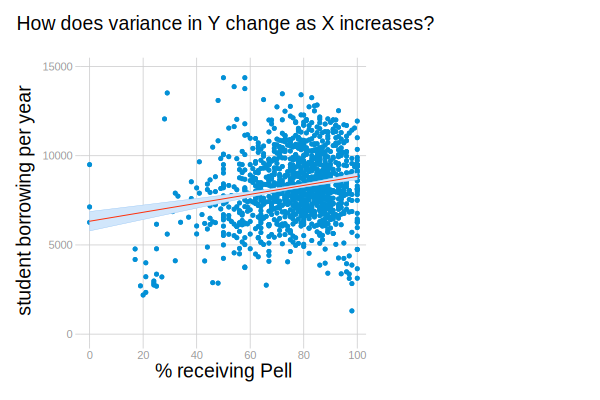

In [32]:
quietly cd ../week9
quietly use forprofits20200317, clear
tw (scatter loan_amount_borrower_c_w fed_grant_pct_w) ///
(lfitci loan_amount_borrower_c_w fed_grant_pct_w),  ///
ytitle(student borrowing per year, size(large)) ///
xtitle(,size(large)) legend(off) scheme(538w) ///
title("How does variance in Y change as X increases?" " ", span size(large)) ///
aspect(1, place(west))

### Histograms can also show if variances are skewed

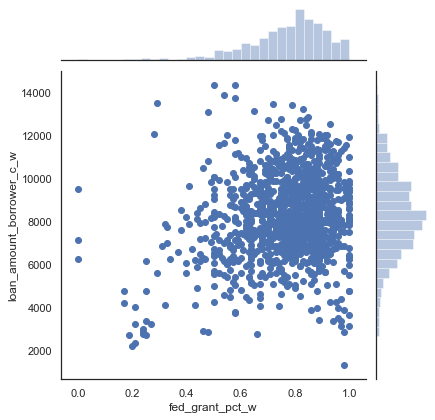

In [9]:
cd .. /week9
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style="white", color_codes=True)
dfforprofit = pd.read_stata('forprofits20200317.dta')
g = sns.jointplot(x="fed_grant_pct_w", y="loan_amount_borrower_c_w", data=dfforprofit)

### Use regression tests to be sure

Breusch–Pagan heteroscedasticity "hettest" is standard:

In [8]:
quietly regress loan_amount_borrower_c_w fed_grant_pct_w
estat hettest




Breusch-Pagan / Cook-Weisberg test for heteroskedasticity 
         Ho: Constant variance
         Variables: fitted values of loan_amount_borrower_c_w

         chi2(1)      =    14.99
         Prob > chi2  =   0.0001


## 2. Nonlinear estimation solutions

We learned these in week 7:

* change in increments (sequential dummy variables)

* change direction or strength abruptly (spline)

* change direction gradually (quadratic)

* accelerate/decelerate -- i.e. curve (logarithmic)

Does this help in the case of average loan debt?

In [33]:
gen loan_amount_borrower_c_wln=log(loan_amount_borrower_c_w)
quietly regress loan_amount_borrower_c_wln fed_grant_pct_w
estat hettest





Breusch-Pagan / Cook-Weisberg test for heteroskedasticity 
         Ho: Constant variance
         Variables: fitted values of loan_amount_borrower_c_wln

         chi2(1)      =    44.43
         Prob > chi2  =   0.0000


## 3. Bootrapping is another solution

Bootstrapping approximates resampling by taking the observed sample as a proxy for the population and repeatedly sampling, with replacement, observations from the observed sample (Treimann 239).

By taking repeated samples and reestimating standard errors, we can better estimate the standard deviation of potential regression coefficients for repeated samples of the population (aka the standard error of the coefficient).

This works the same ways as the standard error of the mean:

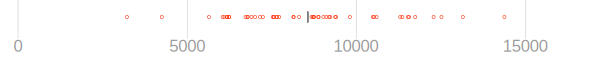

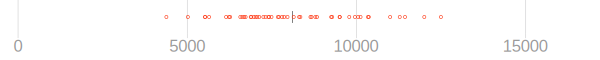

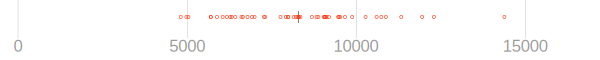

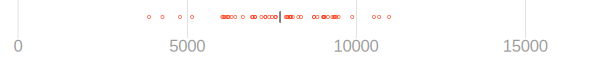

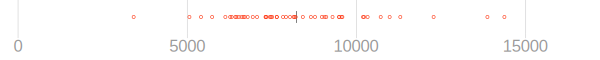

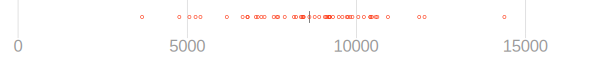

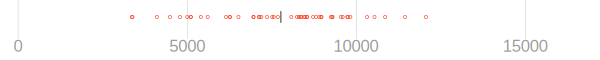

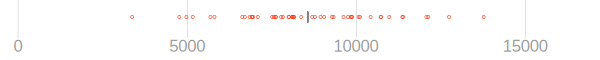

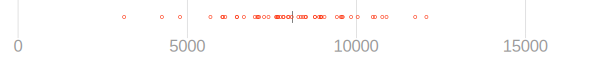

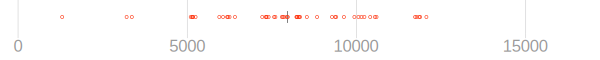







. quietly {


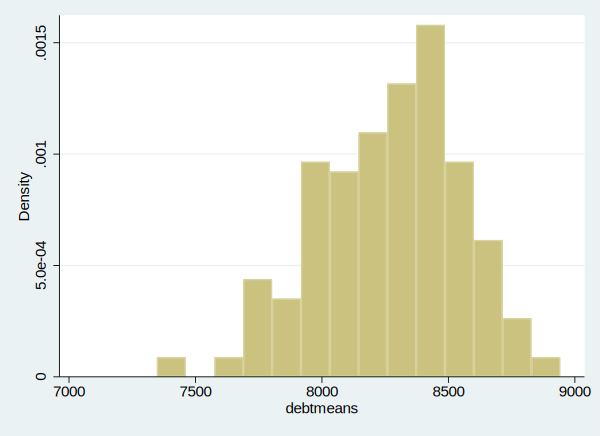

In [8]:
quietly use forprofits20200317, clear
quietly keep if loan_amount_borrower_c_w!=.
quietly gen debtmeans=.
quietly gen n=_n
forvalues i=1/10 {
    quietly gen random=runiform()
    quietly sort random
    quietly stripplot loan_amount_borrower_c_w if _n<=50, scheme(538w) refline  ///
    ysize(1) xsize(10) scale(5) xtitle("") xlabel(0(5000)17000, labsize(vlarge)) 
    graph display, margins(zero)
    quietly sum loan_amount_borrower_c_w if _n<=50
    quietly replace debtmeans=r(mean) if n==`i'
    drop random
    }
quietly {
 forvalues i=11/200 {
    quietly gen random=runiform()
    quietly sort random    
    quietly sum loan_amount_borrower_c_w if _n<=50
    quietly replace debtmeans=r(mean) if n==`i'
    quietly drop random
}
quietly histogram debtmeans
}
graph display

### Lets compare OLS standard errors with bootstrapped standard errors:

In [25]:
est clear
quietly reg loan_amount_borrower_c_w fed_grant_pct_w
quietly eststo
quietly bootstrap _b[fed_grant_pct_w] , rep(1000) nodots : ///
   reg loan_amount_borrower_c_w fed_grant_pct_w
quietly eststo

In [26]:
%html
esttab, html ///
mlabels("OLS" "Bootstrap") ///
collabels(none) drop(_cons) ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001) 

This front-end or document format cannot display HTML

### 4. Robust standard errors solution

* Robust standard errors: error estimates that apply more weight to larger deviations and less weight to smaller deviations

<img src="robusterrorfunctions.png" width="600" align="left">

* This is computationally much more efficient/faster than bootstrapping

* The code is also simpler

In [27]:
quietly reg loan_amount_borrower_c_w fed_grant_pct_w, ro
quietly eststo

In [28]:
%html
esttab, html ///
mlabels("OLS" "Bootstrap" "Robust") ///
collabels(none) drop(_cons) ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001) 

This front-end or document format cannot display HTML

## 5. Cluster Robust standard errors

* Cluster robust standard errors are necessary when your data measures indivdual units within groups that can affect measurement patterns.

* An example of this would be a study student learning (DV) of 1,000 students who are enrolled in 100 different schools. Ideally, you would have a variable that records which school each student is in.

* For the for-profit study, I measure student debt (DV) by school based on the Pell enrollment (IV) of each school. But multiple for-profit colleges are owned by parent companies some times. So I need to cluster standard errors by the **"parentid"** indicating the company owning a school:

In [29]:
qui reg loan_amount_borrower_c_w fed_grant_pct_w, cluster(systemid)
quietly eststo

In [30]:
%html
esttab, html ///
mlabels("OLS" "Bootstrap" "Robust" "Cluster") ///
collabels(none) drop(_cons) ///
cells(b(star fmt(2)) se(fmt(2) par)) ///
starlevels(^ .1 * .05 ** .01 *** .001) 

This front-end or document format cannot display HTML